In [ ]:
import tensorflow as tf
import matplotlib.pyplot as plt
import os
import random
from PIL import Image
import cv2
import numpy as np
from tensorflow.keras.applications.vgg16 import preprocess_input
from tensorflow.keras.preprocessing.image import img_to_array, load_img
from tensorflow.keras.preprocessing.image import ImageDataGenerator, img_to_array, load_img
from tensorflow.keras.applications.vgg16 import preprocess_input
import os
from sklearn.model_selection import train_test_split

In [ ]:
gpu_info = !nvidia-smi
gpu_info = '\n'.join(gpu_info)
if gpu_info.find('failed') >= 0:
  print('Not connected to a GPU')
else:
  print(gpu_info)

Tue Sep  5 11:02:20 2023       
+-----------------------------------------------------------------------------+
| NVIDIA-SMI 525.105.17   Driver Version: 525.105.17   CUDA Version: 12.0     |
|-------------------------------+----------------------+----------------------+
| GPU  Name        Persistence-M| Bus-Id        Disp.A | Volatile Uncorr. ECC |
| Fan  Temp  Perf  Pwr:Usage/Cap|         Memory-Usage | GPU-Util  Compute M. |
|                               |                      |               MIG M. |
|===============================+======================+======================|
|   0  Tesla T4            Off  | 00000000:00:04.0 Off |                    0 |
| N/A   36C    P8     9W /  70W |      0MiB / 15360MiB |      0%      Default |
|                               |                      |                  N/A |
+-------------------------------+----------------------+----------------------+
                                                                               
+-------

In [ ]:
from psutil import virtual_memory
ram_gb = virtual_memory().total / 1e9
print('Your runtime has {:.1f} gigabytes of available RAM\n'.format(ram_gb))

if ram_gb < 20:
  print('Not using a high-RAM runtime')
else:
  print('You are using a high-RAM runtime!')

Your runtime has 54.8 gigabytes of available RAM

You are using a high-RAM runtime!


In [ ]:
from google.colab import drive
drive.mount('/content/drive')

Mounted at /content/drive


In [ ]:
import zipfile
import shutil
import os


zip_file_18000_path = "/content/drive/My Drive/output_folder_18000.zip"

output_folder_18000 = "/content/output_folder_18000"



if os.path.exists(output_folder_18000):
    shutil.rmtree(output_folder_18000)

output_folder_9000 = "/content/"
output_folder_18000 = "/content/"



# Unzip
with zipfile.ZipFile(zip_file_18000_path, 'r') as zip_ref:
    zip_ref.extractall(output_folder_18000)

print("Unzipping and refreshing completed.")

Unzipping and refreshing completed.


In [ ]:
import os
from sklearn.model_selection import train_test_split
from tensorflow.keras.preprocessing.image import load_img, img_to_array
import numpy as np

# Paths
output_subfolder_0 = "/content/output_folder_18000/0"
output_subfolder_1 = "/content/output_folder_18000/1"

# Collect file paths of images
class_0_images = [os.path.join(output_subfolder_0, filename) for filename in os.listdir(output_subfolder_0)]
class_1_images = [os.path.join(output_subfolder_1, filename) for filename in os.listdir(output_subfolder_1)]

# Combine the lists and labels
all_data = class_0_images + class_1_images
all_labels = [0] * len(class_0_images) + [1] * len(class_1_images)

# Split dataset
train_data, temp_data, train_labels, temp_labels = train_test_split(all_data, all_labels, test_size=0.3, random_state=42)
valid_data, test_data, valid_labels, test_labels = train_test_split(temp_data, temp_labels, test_size=0.5, random_state=42)

def load_and_preprocess_image(image_path):
    img = load_img(image_path, target_size=(50, 50))
    img_array = img_to_array(img)
    img_array = np.expand_dims(img_array, axis=0)
    img_array /= 255.
    return img_array

# Convert images to numpy arrays
train_images = np.vstack([load_and_preprocess_image(img_path) for img_path in train_data])
valid_images = np.vstack([load_and_preprocess_image(img_path) for img_path in valid_data])

In [ ]:
from tensorflow.keras.models import Sequential
from tensorflow.keras.layers import Conv2D, MaxPooling2D, Flatten
from tensorflow.keras.optimizers import Adam

cnn_model = Sequential([
    Conv2D(32, (3, 3), activation='relu', input_shape=(50, 50, 3)),
    MaxPooling2D(2, 2),
    Conv2D(64, (3, 3), activation='relu'),
    MaxPooling2D(2, 2),
    Conv2D(128, (3, 3), activation='relu'),
    MaxPooling2D(2, 2),
    Flatten()
])

# Compile and train just to tune the feature extraction parts (we won't use the labels yet)
cnn_model.compile(optimizer=Adam(), loss="binary_crossentropy")
cnn_model.summary()

Model: "sequential"
_________________________________________________________________
 Layer (type)                Output Shape              Param #   
 conv2d (Conv2D)             (None, 48, 48, 32)        896       
                                                                 
 max_pooling2d (MaxPooling2D  (None, 24, 24, 32)       0         
 )                                                               
                                                                 
 conv2d_1 (Conv2D)           (None, 22, 22, 64)        18496     
                                                                 
 max_pooling2d_1 (MaxPooling  (None, 11, 11, 64)       0         
 2D)                                                             
                                                                 
 conv2d_2 (Conv2D)           (None, 9, 9, 128)         73856     
                                                                 
 max_pooling2d_2 (MaxPooling  (None, 4, 4, 128)        0

In [ ]:
train_features = cnn_model.predict(train_images)
valid_features = cnn_model.predict(valid_images)

85/85 [==============================] - 0s 3ms/step


In [ ]:
from sklearn.svm import SVC
from sklearn.metrics import accuracy_score

svm = SVC(kernel='linear')
svm.fit(train_features, train_labels)

# Validation
valid_predictions = svm.predict(valid_features)
accuracy = accuracy_score(valid_labels, valid_predictions)
print(f"SVM validation accuracy: {accuracy * 100:.2f}%")

SVM validation accuracy: 79.74%


In [ ]:
from sklearn.metrics import classification_report, confusion_matrix, roc_curve, roc_auc_score
import matplotlib.pyplot as plt

# Generate classification report
class_report_svm = classification_report(valid_labels, valid_predictions)
print("SVM Classification Report:\n", class_report_svm)

# Generate confusion matrix
conf_matrix_svm = confusion_matrix(valid_labels, valid_predictions)
print("SVM Confusion Matrix:\n", conf_matrix_svm)

SVM Classification Report:
               precision    recall  f1-score   support

           0       0.77      0.85      0.81      1340
           1       0.84      0.74      0.79      1360

    accuracy                           0.80      2700
   macro avg       0.80      0.80      0.80      2700
weighted avg       0.80      0.80      0.80      2700

SVM Confusion Matrix:
 [[1142  198]
 [ 349 1011]]


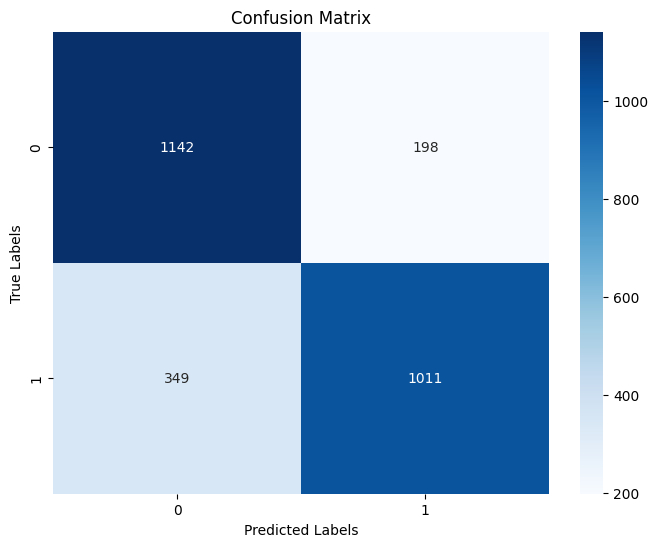

In [ ]:
import matplotlib.pyplot as plt
import seaborn as sns
from sklearn.metrics import confusion_matrix

# Predictions on validation set
valid_preds = svm.predict(valid_features)

# Create confusion matrix
cm = confusion_matrix(valid_labels, valid_preds)

plt.figure(figsize=(8, 6))
sns.heatmap(cm, annot=True, fmt='g', cmap='Blues')
plt.title('Confusion Matrix')
plt.xlabel('Predicted Labels')
plt.ylabel('True Labels')
plt.show()

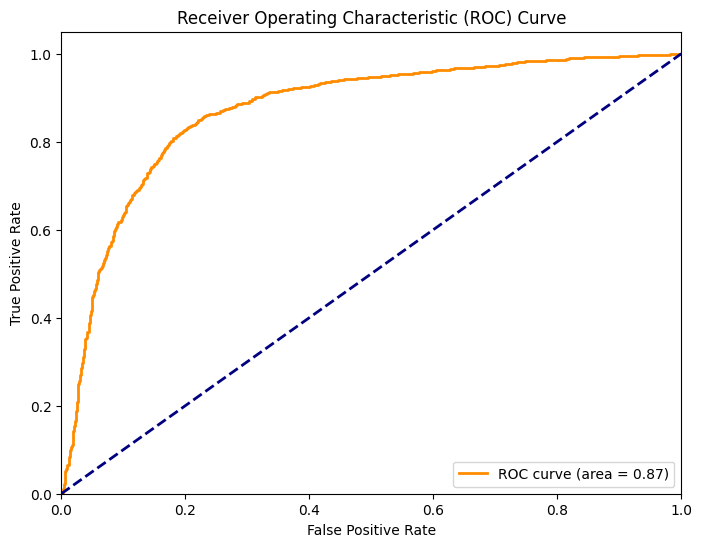

In [ ]:
from sklearn.metrics import roc_curve, auc

# Get the scores for the positive class
scores = svm.decision_function(valid_features)

fpr, tpr, thresholds = roc_curve(valid_labels, scores)
roc_auc = auc(fpr, tpr)

plt.figure(figsize=(8, 6))
plt.plot(fpr, tpr, color='darkorange', lw=2, label=f'ROC curve (area = {roc_auc:.2f})')
plt.plot([0, 1], [0, 1], color='navy', lw=2, linestyle='--')
plt.xlim([0.0, 1.0])
plt.ylim([0.0, 1.05])
plt.xlabel('False Positive Rate')
plt.ylabel('True Positive Rate')
plt.title('Receiver Operating Characteristic (ROC) Curve')
plt.legend(loc="lower right")
plt.show()

In [ ]:
# We'll continue from where you left off
from sklearn.ensemble import RandomForestClassifier
from sklearn.metrics import accuracy_score

# Define the Random Forest classifier
rf_classifier = RandomForestClassifier(n_estimators=100, random_state=42)
rf_classifier.fit(train_features, train_labels)

# Validation
valid_predictions = rf_classifier.predict(valid_features)
accuracy = accuracy_score(valid_labels, valid_predictions)
print(f"Random Forest validation accuracy: {accuracy * 100:.2f}%")

Random Forest validation accuracy: 80.70%


In [ ]:
from sklearn.metrics import classification_report, confusion_matrix, roc_curve, roc_auc_score
import matplotlib.pyplot as plt

# Generate classification report
class_report = classification_report(valid_labels, valid_predictions)
print("Classification Report:\n", class_report)

# Generate confusion matrix
conf_matrix = confusion_matrix(valid_labels, valid_predictions)
print("Confusion Matrix:\n", conf_matrix)

# Generate ROC curve and calculate ROC AUC
probabilities = rf_classifier.predict_proba(valid_features)[:, 1]
fpr, tpr, thresholds = roc_curve(valid_labels, probabilities)
roc_auc = roc_auc_score(valid_labels, probabilities)



Classification Report:
               precision    recall  f1-score   support

           0       0.78      0.85      0.81      1340
           1       0.84      0.76      0.80      1360

    accuracy                           0.81      2700
   macro avg       0.81      0.81      0.81      2700
weighted avg       0.81      0.81      0.81      2700

Confusion Matrix:
 [[1139  201]
 [ 320 1040]]


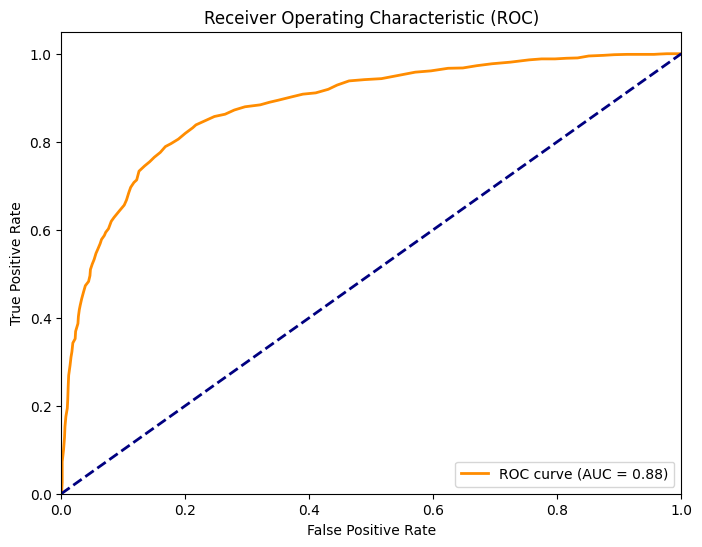

In [ ]:
# Plot ROC curve
plt.figure(figsize=(8, 6))
plt.plot(fpr, tpr, color='darkorange', lw=2, label=f'ROC curve (AUC = {roc_auc:.2f})')
plt.plot([0, 1], [0, 1], color='navy', lw=2, linestyle='--')
plt.xlim([0.0, 1.0])
plt.ylim([0.0, 1.05])
plt.xlabel('False Positive Rate')
plt.ylabel('True Positive Rate')
plt.title('Receiver Operating Characteristic (ROC)')
plt.legend(loc='lower right')
plt.show()

In [ ]:
from sklearn.ensemble import VotingClassifier
from sklearn.model_selection import cross_val_score

# Since SVC with kernel 'linear' doesn't give probabilities by default,
# we need to set probability=True to enable the predict_proba method,
# which is required for soft voting.
svm_clf = SVC(kernel='linear', probability=True)

# Create the ensemble model
ensemble_model = VotingClassifier(estimators=[
    ('svm', svm_clf),
    ('rf', rf_classifier)
], voting='soft')

ensemble_model.fit(train_features, train_labels)

# Validation
ensemble_valid_predictions = ensemble_model.predict(valid_features)
ensemble_accuracy = accuracy_score(valid_labels, ensemble_valid_predictions)
print(f"Ensemble model validation accuracy: {ensemble_accuracy * 100:.2f}%")

Ensemble model validation accuracy: 80.89%


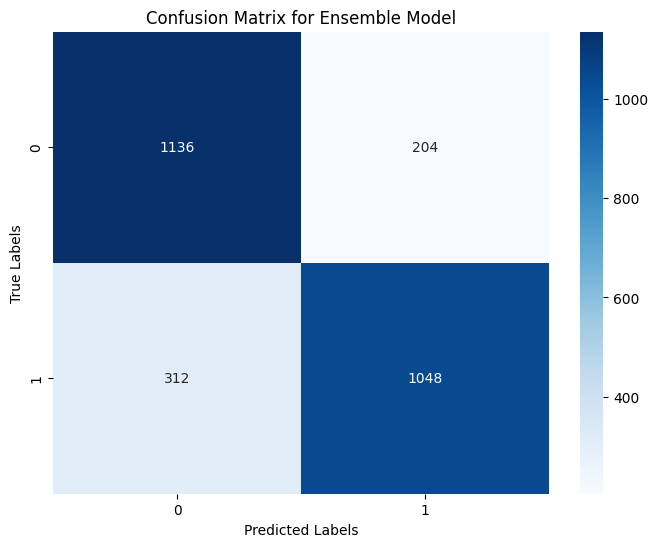

Classification Report for Ensemble Model:
              precision    recall  f1-score   support

     Class 0       0.78      0.85      0.81      1340
     Class 1       0.84      0.77      0.80      1360

    accuracy                           0.81      2700
   macro avg       0.81      0.81      0.81      2700
weighted avg       0.81      0.81      0.81      2700



In [ ]:
from sklearn.metrics import confusion_matrix, classification_report, roc_curve, auc
import matplotlib.pyplot as plt
import seaborn as sns

# Predictions on validation set
ensemble_valid_preds = ensemble_model.predict(valid_features)

# Create confusion matrix
cm = confusion_matrix(valid_labels, ensemble_valid_preds)

# Plot confusion matrix
plt.figure(figsize=(8, 6))
sns.heatmap(cm, annot=True, fmt='g', cmap='Blues')
plt.title('Confusion Matrix for Ensemble Model')
plt.xlabel('Predicted Labels')
plt.ylabel('True Labels')
plt.show()

# Calculate and print classification report
report = classification_report(valid_labels, ensemble_valid_preds, target_names=['Class 0', 'Class 1'])
print("Classification Report for Ensemble Model:")
print(report)



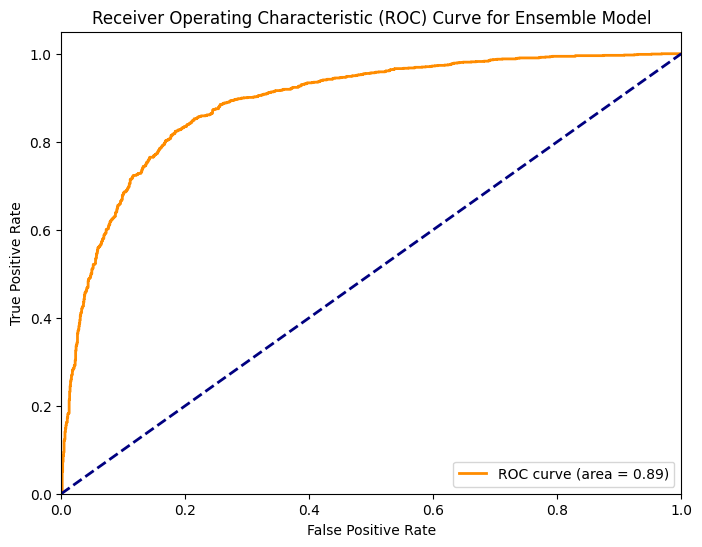

In [ ]:
# ROC Curve
# Get the scores for the positive class
ensemble_scores = ensemble_model.predict_proba(valid_features)[:, 1]

fpr, tpr, thresholds = roc_curve(valid_labels, ensemble_scores)
roc_auc = auc(fpr, tpr)

plt.figure(figsize=(8, 6))
plt.plot(fpr, tpr, color='darkorange', lw=2, label=f'ROC curve (area = {roc_auc:.2f})')
plt.plot([0, 1], [0, 1], color='navy', lw=2, linestyle='--')
plt.xlim([0.0, 1.0])
plt.ylim([0.0, 1.05])
plt.xlabel('False Positive Rate')
plt.ylabel('True Positive Rate')
plt.title('Receiver Operating Characteristic (ROC) Curve for Ensemble Model')
plt.legend(loc="lower right")
plt.show()